DP-Histogram and Non-private ERM for Logistic Regression

**Laplace mechanism** is used to build a noisy histogram. The released (differentially private) noisy histogram can be used to generate synthetic data. In the second part, a logistic regression model is built to perform a classfication task and train it using the **gradient descent** algorithm. Logistic regression problem is considered in non-private setting. 

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

# Section 1: Private Synthetic Data Generation via Noisy Histograms


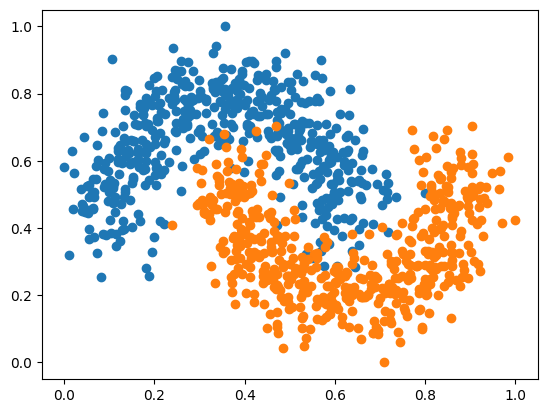

In [37]:
df = pd.read_csv("/content/dataset_hw4.csv", names=['x1', 'x2', 'y'])
plt.scatter(df[df['y'] == 0]['x1'], df[df['y'] == 0]['x2'], c='C0')
plt.scatter(df[df['y'] == 1]['x1'], df[df['y'] == 1]['x2'], c='C1')

Implement the function that constructs a histogram.

In [38]:
import numpy as np
import pandas as pd

def construct_histogram(X, n_split):
    """
    Parameters:
    --------------------------
    X: 2D array of size (n, 2), containing observations
    n_split: integer, the number of intervals to have on each dimension

    Return:
    -------------------------
    h: 1D array containing bin counts; the bins are enumerated from left to
       right and top to bottom.
    """
    # Setting the range
    X = np.clip(X, 0, 1)

    # Creating the bin edges for each dimension
    edges_x1 = np.linspace(0, 1, n_split + 1)
    edges_x2 = np.linspace(0, 1, n_split + 1)

    # Digitizing the observations into the bins
    indices_x1 = np.digitize(X[:, 0], edges_x1, right=False) - 1
    indices_x2 = np.digitize(X[:, 1], edges_x2, right=False) - 1

    # Ensuring valid range of indices
    indices_x1 = np.clip(indices_x1, 0, n_split - 1)
    indices_x2 = np.clip(indices_x2, 0, n_split - 1)

    hx = np.zeros((n_split, n_split), dtype=int)

    # Count occurrences in each bin
    for i in range(len(X)):
        hx[indices_x1[i], indices_x2[i]] += 1


    h = []
    for i in range(n_split):
        for j in range(n_split-1,-1,-1):
            h.append(hx[i, j])

    return h

# Load the dataset
data = pd.read_csv('/content/dataset_hw4.csv', names=['x1', 'x2', 'y'])
X = data[['x1', 'x2']].values

# Input the number of splits (bins)
n_split = int(input("Enter the number of splits (bins): "))

# Construct the histogram
histogram_counts = construct_histogram(X, n_split)

# Print the histogram counts
print(histogram_counts)


Enter the number of splits (bins): 2
[343, 181, 152, 324]


Releasing the histogram using the Laplace mechanism


Derive the sensitivity of releasing the histogram under both proper subset and replacement definition.


In [ ]:

### Mathematical Explanation for Sensitivity of Released Histogram
For example,
We are given the following histogram counts based on a dataset from construct_histogram function described above:
```
h = [343, 152, 181, 324]
```
Sensitivity measures the maximum possible change in the function output (histogram) when one data point is removed (for the proper subset definition) or changed (for the replacement definition).
Datasets D and D' are neighboring datasets if they differ by a single record of an individual.

q(D) is a query function ON dataset D.
For a histogram, 𝑞(𝐷) could be defined as the vector of counts in each bin of the histogram created from the dataset 𝐷
q(D)=h
Similarly, q(D') = h'
$$
\Delta Sensitivity = \max_{D, D'} \| q(D) - q(D') \|_1 = \max_{D, D'} \|h - h'\|_1
$$

###  1: Sensitivity under proper subset Definition

In the **subset definition**, neighboring datasets differ by the removal of a single point. In the case of histogram generated, one bin’s count decreases by 1, and no other bins are affected. If a data point that contributes to one specific bin (the first bin with a count of 343) is removed from histogram h, the counts will change from 343 to 342, while other bins remain the same. This results in:

Initial Histogram:
```
ℎ=[343,152,181,324]
```

After change:
```
h`=[342,152,181,324]
```
The absolute change in the histogram can be expressed using the \(L_1\) norm (sum of absolute differences):

$$
\Delta q_{\text{subset}} = \max_{D, D'} \| h - h' \|_1 = | 343 - 342 | + | 152 - 152 | + | 181 - 181 | + | 324 - 324 |  = |1| + 0 + 0 + 0 = 1
$$

The same reasoning applies for any of the bins. Removing a data point from any bin results in a change of −1 for that bin and 0 for all others.
Thus, the **sensitivity under the subset definition** is 1:

$$
\Delta q_{\text{subset}} = 1
$$

###  2: Sensitivity under Replacement Definition

In the **replacement definition**, we compare two neighboring datasets $D$ and $D'$ where one data point in $D$ is replaced by another point in $D'$.

For a histogram, this replacement affects at most two bins:
- One bin’s count decreases by 1 (the bin where the point is removed).
- Another bin’s count increases by 1 (the bin where the new point is added).

When a data point corresponding to a specific bin is replaced, the counts can change in two ways:
1) Decrease in one bin: If a data point contributing to a specific bin (e.g., bin with count 343) is replaced by a data point that does not belong to that bin, the count in that bin decreases by 1.

2) Increase in another bin: Simultaneously, the count in the bin corresponding to the new data point increases by 1.

Assuming we replace a data point from the first bin with one that belongs to the second bin:

Initial Histogram:
```
ℎ=[343,152,181,324]
```
After Replacement: If a data point from bin 1 is replaced with one from bin 2, the new histogram becomes:
```
ℎ′=[342,153,181,324]
```
Thus, the absolute change in the histogram for neighboring datasets is:

$$
\Delta q_{\text{replacement}} = \max_{D, D'} \| h - h' \|_1 = | 343 - 342 | + | 152 - 153 | + | 181 - 181 | + | 324 - 324 |  = | 1 | + | -1 | + 0 + 0 = 2
$$

Therefore, the **sensitivity under replacement** is 2 :

$$
\Delta q_{\text{replacement}} = 2
$$

---


 Function that releases a histogram using the Laplace mechanism.



In [39]:
def dp_histogram(histo, epsilon):
    """
    Parameters:
    ------------------------
    histo: 1D array containing count values of a histogram
    epsilon: privacy budget, a real number greater than 0.

    Returns:
    ------------------------
    noisy_histo: 1D array containing normalized count values, i.e., probabilities for each bin
    """
    sensitivity = 1 #Using sensitivity obtained from previous step of proper subset definition
    lambda_ = sensitivity / epsilon

    # Adding Laplace noise to each bin of the histogram
    noisy_histo = histo + np.random.laplace(0, lambda_, size=len(histo))

    # Ensuring no negative values in the noisy histogram
    noisy_histo = np.maximum(0, noisy_histo)

    # Normalizing the noisy histogram to sum to 1 (turn counts into probabilities)
    total_count = np.sum(noisy_histo)
    if total_count > 0:
        noisy_histo = noisy_histo / total_count
    else:
        noisy_histo = np.zeros_like(noisy_histo)
    return noisy_histo
epsilon = 3.0
dp_histogram_counts = dp_histogram(histogram_counts, epsilon)

print("Differentially Private Histogram (Noisy Counts):\n", dp_histogram_counts)

Differentially Private Histogram (Noisy Counts):
 [0.34293503 0.18100616 0.1517219  0.32433691]


### Generating a synthetic dataset using the noisy histogram

Function that generates a synthetic dataset of size 1,000.

In [40]:
import numpy as np
import matplotlib.pyplot as plt


def synthesize_dataset(noisy_histo, dataset_size):
    """

    """
    syn_dataset = []

    total_count = sum([count for _, _, count, _ in noisy_histo])
    scaling_factor = dataset_size / total_count

    # Loop over each bin in the noisy histogram
    for range_x, range_y, count, prob in noisy_histo:

        num_samples = int(count * scaling_factor)

        # Generating num_samples samples uniformly within [si1, fi1) x [si2, fi2)
        samples_x = np.random.uniform(low=range_x[0], high=range_x[1], size=num_samples)
        samples_y = np.random.uniform(low=range_y[0], high=range_y[1], size=num_samples)

        # Combine x and y samples and add them to the synthetic dataset
        bin_samples = np.column_stack((samples_x, samples_y))
        syn_dataset.append(bin_samples)

    # Concatenate all the samples from all bins to create the full synthetic dataset
    syn_dataset = np.vstack(syn_dataset)

    # If more samples than requested, randomly select the required number
    if len(syn_dataset) > dataset_size:
        syn_dataset = syn_dataset[np.random.choice(len(syn_dataset), dataset_size, replace=False)]

    return syn_dataset



#This function is same as the first function in the file, except that it returns two more values i.e. edges
def construct_histogram(X, n_split):
    """
    Parameters:
    --------------------------
    X: 2D array of size (n, 2), containing observations
    n_split: integer, the number of intervals to have on each dimension

    Return:
    -------------------------
    h: 1D array containing bin counts
    edges_x1, edges_x2: bin edges for both dimensions
    """
    # Ensure the data is in range [0, 1)
    X = np.clip(X, 0, 1)

    # Create the bin edges for each dimension
    edges_x1 = np.linspace(0, 1, n_split + 1)
    edges_x2 = np.linspace(0, 1, n_split + 1)

    # Digitize the observations into the bins
    indices_x1 = np.digitize(X[:, 0], edges_x1, right=False) - 1
    indices_x2 = np.digitize(X[:, 1], edges_x2, right=False) - 1

    # Ensure indices are within valid range
    indices_x1 = np.clip(indices_x1, 0, n_split - 1)
    indices_x2 = np.clip(indices_x2, 0, n_split - 1)

    # Create a 2D histogram to count the number of observations in each bin
    hx = np.zeros((n_split, n_split), dtype=int)
    for i in range(len(X)):
        hx[indices_x1[i], indices_x2[i]] += 1
    #Enumerating bins
    h=[]
    for i in range(n_split - 1, -1, -1):  # Starting with top row, then bottom row
        for j in range(n_split):  # Move left to right in each row
            h.append(hx[i, j])
    # Flatten the histogram to return it as a 1D array and bin edges
    return h, edges_x1, edges_x2




def construct_noisy_histogram(X, n_split, epsilon):
    """
    Constructs a noisy histogram with bin ranges, noisy counts, and probabilities.

    Parameters:
    -------------------------
    X: 2D array of observations
    n_split: number of intervals to have on each dimension
    epsilon: privacy budget for differential privacy

    Returns:
    -------------------------
    noisy_histogram: list of tuples, where each tuple contains:
        ([si1, fi1), [si2, fi2), counti, probi)
    """

    histo, edges_x1, edges_x2 = construct_histogram(X, n_split)


    noisy_counts = dp_histogram(histo, epsilon)

    # Step 3: Construct the noisy histogram
    noisy_histogram = []
    for i in range(n_split):
        for j in range(n_split):
            bin_index = i * n_split + j  # Flattened index
            range_x1 = [edges_x1[i], edges_x1[i+1]]
            range_x2 = [edges_x2[j], edges_x2[j+1]]
            count = histo[bin_index]
            prob = noisy_counts[bin_index]
            noisy_histogram.append((range_x1, range_x2, count, prob))

    return noisy_histogram

#To view a synthetic dataset
data = pd.read_csv('/content/dataset_hw4.csv', names=['x1', 'x2', 'y'])
X = data[['x1', 'x2']].values
epsilonv =3.0
n_split_values =2
noisy_histogram = construct_noisy_histogram(X, n_split, epsilon)
syn_dataset = synthesize_dataset(noisy_histogram, dataset_size=1000)
print(syn_dataset)

[[0.3243779  0.20441707]
 [0.35050628 0.33279039]
 [0.03616485 0.28640822]
 ...
 [0.58014107 0.76058131]
 [0.81156861 0.6693741 ]
 [0.61569196 0.92116711]]


Generate and visualize the synthetic datasets.
- generate datasets using three different values of epsilon = 0.1, 1.0, 10.0 and for three different values of `n_split`=2, 4, 8.


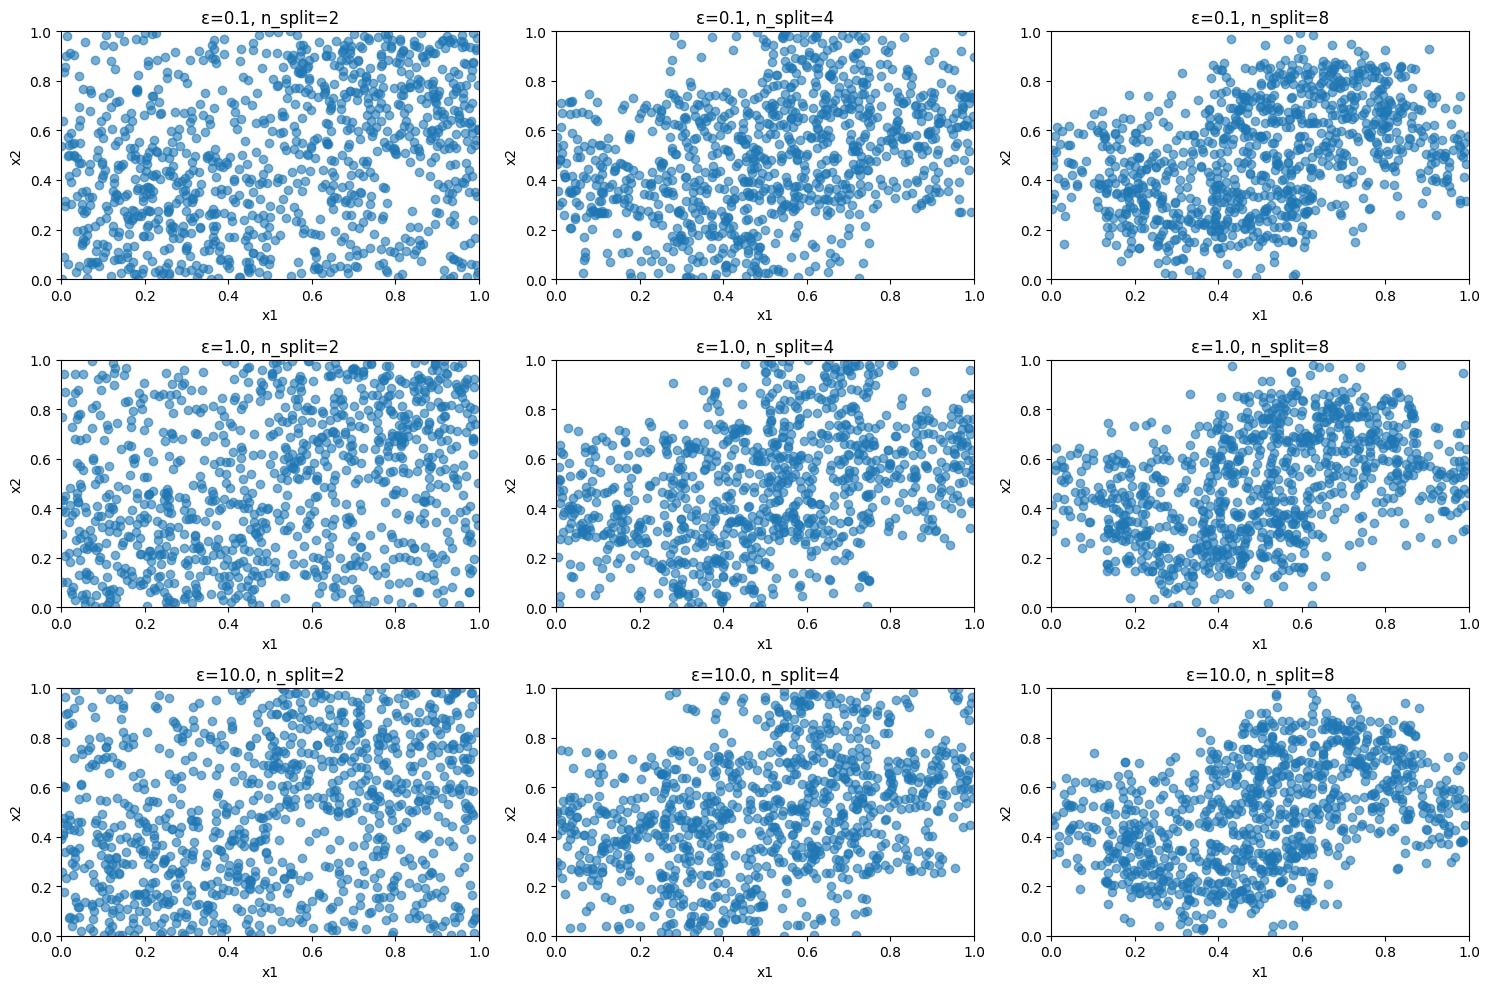

In [41]:
data = pd.read_csv('/content/dataset_hw4.csv', names=['x1', 'x2', 'y'])
X = data[['x1', 'x2']].values

datasets = {}

epsilon_values = [0.1, 1.0, 10.0]
n_split_values = [2, 4, 8]

for epsilon in epsilon_values:
    for n_split in n_split_values:
        noisy_histogram = construct_noisy_histogram(X, n_split, epsilon)
        syn_dataset = synthesize_dataset(noisy_histogram, dataset_size=1000)

        datasets[(epsilon, n_split)] = syn_dataset

# Step 2: Visualize the Datasets
fig, axs = plt.subplots(len(epsilon_values), len(n_split_values), figsize=(15, 10))

for i, epsilon in enumerate(epsilon_values):
    for j, n_split in enumerate(n_split_values):
        axs[i, j].scatter(datasets[(epsilon, n_split)][:, 0], datasets[(epsilon, n_split)][:, 1], alpha=0.6)
        axs[i, j].set_title(f"ε={epsilon}, n_split={n_split}")
        axs[i, j].set_xlim(0, 1)
        axs[i, j].set_ylim(0, 1)
        axs[i, j].set_xlabel("x1")
        axs[i, j].set_ylabel("x2")

plt.tight_layout()
plt.show()


In [50]:
print("""Q5-results trade off-explanation- Graphs are plotted with ranges x1 and x2 on x-axis and y-axis respectively.
The above results illustrate the privacy-utility trade-off using scatter plots of different parameters, namely: Epsilon (ε) controls the privacy level and n_split controls how data is partitioned or processed.
Key Observations:
Effect of Epsilon (ε):

Small ε(0.1) provides more privacy : As seen in the first image (top row), when ε is smaller, the noise added to the data for privacy is greater. The scatter plots appear more "randomized" and noisy. This ensures higher privacy because individual data points are more difficult to distinguish. In the second
image, as ε increases to 1.0, there is a slight reduction in noise that causes improvement in the utility. In the third image, as ε increases to 10.0, the noise reduces, and the data points look more clustered and organized. This implies lower privacy but higher utility, as the added noise is not as disruptive to the underlying patterns.It is easy for the adversary to distinguish the data.

Effect of n_split:

Lower n_split (2): With fewer splits, the points are more randomly scattered, indicating a higher degree of noise (especially when ε is smaller). This implies more privacy but less utility. As the number of splits increases from 4 to 8, the distributions become clearer, reflecting the true nature of the data.
Higher n_split (8): With higher n_split values, the scatter plot shows a reduction in noise (especially visible when ε = 1.0 and ε = 10.0). This suggests that while more splitting may help refine the data representation, it does not completely negate the effects of added noise for privacy purposes.
It is observed that higher values of epsilon and n_split together constitute more utlity but less privacy. Similarly, lower values of epsilon and n_split together constitute more noise or privacy but less utility.
Privacy-Utility Trade-Off:
Higher Privacy (Low ε): In the first image (top row, ε = 0.1), adding more noise ensures privacy by making individual points indistinguishable, but it also degrades the utility of the data. As we increase the number of splits, the data remains highly noisy.

Lower Privacy (High ε): In the second image (ε = 10.0), the noise is reduced significantly, and the structure of the data becomes clearer, improving utility. However, this also means lower privacy, as individual points are less obscured.So, a balance or perfect trade-off between utility and privacy has to be maintained to make it difficult for adversary to guess individual's data""")

Q5-results trade off-explanation
The above results illustrate the privacy-utility trade-off using scatter plots of different parameters, namely: Epsilon (ε) controls the privacy level and n_split controls how data is partitioned or processed.
Key Observations: 
Effect of Epsilon (ε):

Small ε(0.1) provides more privacy : As seen in the first image (top row), when ε is smaller, the noise added to the data for privacy is greater. The scatter plots appear more "randomized" and noisy. This ensures higher privacy because individual data points are more difficult to distinguish. In the second
image, as ε increases to 1.0, there is a slight reduction in noise that causes improvement in the utility. In the third image, as ε increases to 10.0, the noise reduces, and the data points look more clustered and organized. This implies lower privacy but higher utility, as the added noise is not as disruptive to the underlying patterns.It is easy for the adversary to distinguish the data.

Effect of n_

# Section 2: Logistic Regression

Telco customer churning dataset is used - (http://cobweb.cs.uga.edu/~jwlee/datasets/churn.csv).

### About the dataset
Goal is to build a logistic regression model for predicting whether the customer will churn or not, i.e., the churn column.

| Feature | Description |
|:-------:|:----------:|
|customerID | Customer ID |
| gender | Whether the customer is a male or a female |
| SeniorCitizen | Whether the customer is a senior citizen or not (1, 0)|
|Partner | Whether the customer has a partner or not (Yes, No) |
| Dependents | Whether the customer has dependents or not (Yes, No)|
| tenure | Number of months the customer has stayed with the company|
|PhoneService | Whether the customer has a phone service or not (Yes, No)|
| MultipleLines | Whether the customer has multiple lines or not (Yes, No, No phone service)|
| InternetService | Customer’s internet service provider (DSL, Fiber optic, No)|
| OnlineSecurity | Whether the customer has online security or not (Yes, No, No internet service) |
| OnlineBackup | Whether the customer has online backup or not (Yes, No, No internet service)|
| DeviceProtection | Whether the customer has device protection or not (Yes, No, No internet service)|
| TechSupport | Whether the customer has tech support or not (Yes, No, No internet service)|
| StreamingTV | Whether the customer has streaming TV or not (Yes, No, No internet service)|
| StreamingMovies | Whether the customer has streaming movies or not (Yes, No, No internet service) |
| Contract | The contract term of the customer (Month-to-month, One year, Two year)|
| PaperlessBilling | Whether the customer has paperless billing or not (Yes, No)|
| PaymentMethod | The customer’s payment method (Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic)) |
| MonthlyCharges | The amount charged to the customer monthly|
| TotalCharges | The total amount charged to the customer|
| Churn | Whether the customer churned or not (Yes or No) |

## Part 2. Pre-processing the dataset

In [42]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

# Load the dataset into a DataFrame
df = pd.read_csv('/content/churn.csv')

# Replace empty strings with NaN
df.replace(' ', np.nan, inplace=True)

# Counting the number of rows with NaN values
nan_count = df.isnull().sum(axis=1).gt(0).sum()
print(f"Number of rows with NaN values: {nan_count}")

# displaying the customerID of those rows
if nan_count > 0:
    rows_with_nan = df[df.isnull().any(axis=1)]
    print("\nCustomer IDs of rows with NaN values:")
    print(rows_with_nan['customerID'])

df=df.dropna()
# Specify categorical columns
categorical_columns = ["gender", "Partner", "Dependents", "PhoneService",
                       "MultipleLines", "InternetService", "OnlineSecurity",
                       "OnlineBackup", "DeviceProtection", "TechSupport",
                       "StreamingTV", "StreamingMovies", "Contract",
                       "PaperlessBilling", "PaymentMethod"]


encoded_df = pd.DataFrame()
for column in categorical_columns:
    # Performing one-hot encoding
    one_hot_encoded = pd.get_dummies(df[column], prefix=column, drop_first=False)
    one_hot_encoded = one_hot_encoded.astype(int)
    # Identifying the first value based on actual occurrences
    first_value = df[column].iloc[0]  # Get the first value in the original data

    #  the column corresponding to the first value
    column_to_drop = f"{column}_{first_value}"

    # Dropping the identified column from one-hot encoded DataFrame
    one_hot_encoded.drop(columns=[column_to_drop], inplace=True, errors='ignore')
    encoded_df = pd.concat([encoded_df, one_hot_encoded], axis=1)

# Scaling the three numerical variables
numerical_columns = ['tenure', 'MonthlyCharges', 'TotalCharges']
scaler = MinMaxScaler()

# Scaling the features to the range [0, 1]
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

# Encoding the label column (Churn)
label_encoder = LabelEncoder()
df['Churn'] = label_encoder.fit_transform(df['Churn'].astype(str))  # Map "No" to 0 and "Yes" to 1

# Concatenate with the original DataFrame without the categorical columns
final_df = pd.concat([df.drop(columns=categorical_columns), encoded_df], axis=1)

# Printing the number of observations and features after preprocessing
num_observations, num_features = final_df.shape
print(f'Number of observations: {num_observations}')
print(f'Number of features: {num_features}')

# Save the final DataFrame to a new CSV file
final_df.to_csv('mas.csv', index=False)


Number of rows with NaN values: 11

Customer IDs of rows with NaN values:
488     4472-LVYGI
753     3115-CZMZD
936     5709-LVOEQ
1082    4367-NUYAO
1340    1371-DWPAZ
3331    7644-OMVMY
3826    3213-VVOLG
4380    2520-SGTTA
5218    2923-ARZLG
6670    4075-WKNIU
6754    2775-SEFEE
Name: customerID, dtype: object
Number of observations: 7032
Number of features: 32


Augment the dataset by adding a dummy column of ones .

In [43]:
import pandas as pd
df = pd.read_csv('/content/mas.csv')
dummy_column = pd.Series(1, index=df.index, name='Dummy')
df_augmented = pd.concat([dummy_column, df], axis=1)
df_augmented.to_csv('augmented_dataset.csv', index=False)


Ensure that your dataset has Y in {-1, +1 \}

In [44]:
import pandas as pd


df = pd.read_csv('/content/augmented_dataset.csv')

# Map 0 to -1 and 1 to +1 in the 'Churn' column
df['Churn'] = df['Churn'].replace({0: -1, 1: +1})

# Display the unique values in the 'Churn' column to verify the mapping
unique_values = df['Churn'].unique()
print("Unique values in the 'Churn' column:", unique_values)



df.to_csv('updated_augmented_dataset.csv', index=False)
print(df.head())


Unique values in the 'Churn' column: [-1  1]
   Dummy  customerID  SeniorCitizen    tenure  MonthlyCharges  TotalCharges  \
0      1  7590-VHVEG              0  0.000000        0.115423      0.001275   
1      1  5575-GNVDE              0  0.464789        0.385075      0.215867   
2      1  3668-QPYBK              0  0.014085        0.354229      0.010310   
3      1  7795-CFOCW              0  0.619718        0.239303      0.210241   
4      1  9237-HQITU              0  0.014085        0.521891      0.015330   

   Churn  gender_Male  Partner_No  Dependents_Yes  ...  \
0     -1            0           0               0  ...   
1     -1            1           1               0  ...   
2      1            1           1               0  ...   
3     -1            1           1               0  ...   
4      1            0           1               0  ...   

   StreamingTV_No internet service  StreamingTV_Yes  \
0                                0                0   
1                    

Split the data into train and test sets.

In [45]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv('updated_augmented_dataset.csv')
X = df.drop(columns=['Churn', 'customerID'])
y = df['Churn']   # Target variable ('Churn')

# Splitting the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")



Training set size: 5625 samples
Testing set size: 1407 samples


## Part 2. Logistic Regression Model

Implement the objective function of logistic regression model.


In [ ]:
W = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9], [10, 11, 12]])
alpha = np.array([1, 2, 3])
q = np.array([1, 2, 3, 4])

sum_wa = np.sum(np.dot(W, alpha), axis=0)
print(sum_wa)

164


In [ ]:
log_wa = np.log(np.dot(W, alpha))
print(np.sum(log_wa, axis=0))

14.236323943019237


$$\sum_{i=1}^4 w_i q_i = \text{np.sum}\left\{
\begin{pmatrix}
q_1 \cdot w_1 \\
q_2 \cdot w_2 \\
q_3 \cdot w_3 \\
q_4 \cdot w_4
\end{pmatrix}, axis=0\right\}\,.$$ Refer to the lecture slides on <font color="red">numpy array broadcasting</font>.

In [ ]:
print("q.shape=", q.shape)
q2d = np.atleast_2d(q)
print("q2d.shape=", q2d.shape)
q2d = q2d.T
print("(after transpose) q2d.shape=", q2d.shape)
print(W * q2d)

q.shape= (4,)
q2d.shape= (1, 4)
(after transpose) q2d.shape= (4, 1)
[[ 1  2  3]
 [ 8 10 12]
 [21 24 27]
 [40 44 48]]


In [46]:
import numpy as np

def logres_obj(X, y, beta):
    """
    Returns the logistic regression objective function value.

    Parameters:
    ------------
    X : numpy array of shape (n_samples, n_features)
        Input dataset (features).
    y : numpy array of shape (n_samples,)
        Target vector (labels).
    beta : numpy array of shape (n_features,)
        Parameter vector (weights).

    Output:
    -------
    obj : float
        The logistic loss value (objective value).
    """

    z = np.dot(X, beta.T)
    loss = np.log(1 + np.exp((-y )*( z)))  # Computes log(1 + exp(-y_i * z_i))
    # Compute the average of the logistic loss
    n = X.shape[0]  # Number of samples
    obj = (1 / n) * np.sum(loss)
    return obj



beta = np.zeros(X_train.shape[1])  # Initialize beta to zeros
print("Objective value with beta = 0:", logres_obj(X_train, y_train, beta))

beta = np.ones(X_train.shape[1])  # Initialize beta to ones
print("Objective value with beta = 1:", logres_obj(X_train, y_train, beta))


Objective value with beta = 0: 0.6931471805599454
Objective value with beta = 1: 8.573535130508082


Implement the function that returns the gradient of logistic regression model.

In [51]:
import numpy as np
from scipy.special import expit

def finite_diff_grad(X, y, beta, h=0.00001):
    """
    This function numerically evaluates the gradient of the objective function at beta
    """

    f_beta = logres_obj(X, y, beta)

    p = len(beta)
    grad = np.zeros(p)

    for i in range(p):
        e = np.zeros_like(beta)
        e[i] = h

        # evalute f(x+h)
        f_beta_h1 = logres_obj(X, y, beta+e)

        # evaluate f(x - h)
        f_beta_h2 = logres_obj(X, y, beta-e)

        grad[i] = (f_beta_h1 - f_beta_h2) / (2.0 * h)



    return grad


def logres_grad(X, y, beta):
    """
    Returns the gradient of the logistic regression model.

    Parameters:
    ------------
    X : numpy array
        Input dataset (n_samples x n_features)
    y : numpy array
        Target labels (n_samples,)
    beta : numpy array
        Parameter vector (n_features,)

    Output:
    -------
    grad : 1D numpy array
        Gradient (p, )
    """
    n = X.shape[0]  # Number of samples
    p = X.shape[1]  # Number of features
    z = np.dot(X, beta)
    sigma = expit(y * z)  # σ(y_i β^T x_i), shape (n_samples,)
    grad = (1 / n) * np.dot(X.T, (sigma - 1) * y)  # (n_features, n_samples) @ (n_samples,) = (n_features,)

    return grad


grad_analytic = logres_grad(X, y, beta)
grad_numeric = finite_diff_grad(X, y, beta)

print("L2 distance=", np.linalg.norm(grad_analytic - grad_numeric))
#Outputs a very small value in the order of 10^-10

L2 distance= 1.1798211166653587e-11


Implment the Gradient Descent Algorithm


In [53]:
def grad_desc(X, y, n_iter=100):
    """
    gradient descent algorithm

    Parameters:
    ----------------
    X, y: input dataset
    n_iter: the number of iterations

    Returns:
    -----------
    sol_path : a list of solutions, the kth entry corresponds to the beta
               at iteration k
    obj_vals : a list of object values, the kth entry corresponds to the
               objective value at iteration k
    """
    sol_path = []
    obj_vals = []
    eta = 1.0

    n, p = X.shape
    beta = np.zeros(p)

    for i in range(n_iter):
        gradient = logres_grad(X, y, beta)
        # Updating the beta values
        beta = beta - eta * gradient
        # Storing the current solution and objective value
        sol_path.append(beta.copy())
        obj_vals.append(logres_obj(X, y, beta))

    return beta, sol_path, obj_vals


beta, sol_path, obj_vals= grad_desc(X, y, n_iter=100)




## Prediction

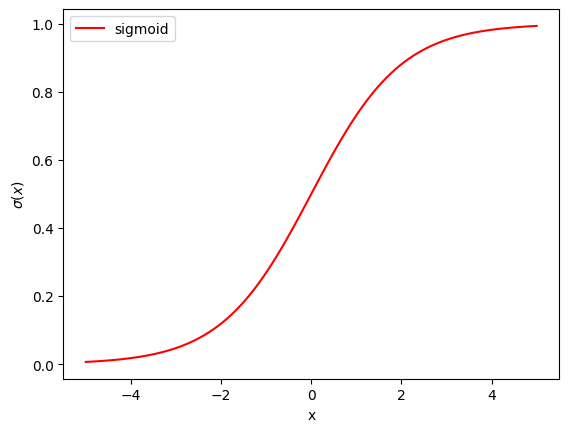

In [ ]:
x = np.linspace(-5, 5, 100)
y = expit(x)

fig, ax = plt.subplots()
ax.plot(x, y, 'r-', label='sigmoid')
ax.set_xlabel('x')
ax.set_ylabel(r'$\sigma(x)$')
ax.legend()

Implement a function that predicts the labels for the given examples.

In [54]:
def predict(X, beta):
    """
    predict the labels of observations in X

    Parameters:
    ----------------
    beta: coefficients
    X: 2D numpy array, a set of observations, an example per row

    Returns:
    y_hat: predicted labels
    """
    z = np.dot(X, beta)

    #decision rule (predict 1 if z >= 0, otherwise -1)
    y_hat = np.where(z >= 0, 1, -1)


    return y_hat

beta, sol_path, obj_vals = grad_desc(X_train, y_train, n_iter=100)

# Predicting churn for the test data
y_pred = predict(X_test, beta)


print(y_pred)



[-1 -1  1 ... -1 -1 -1]


## Part 3. Training


In [55]:

n_iter = 100
beta, sols, objs = grad_desc(X_train, y_train, n_iter=n_iter)

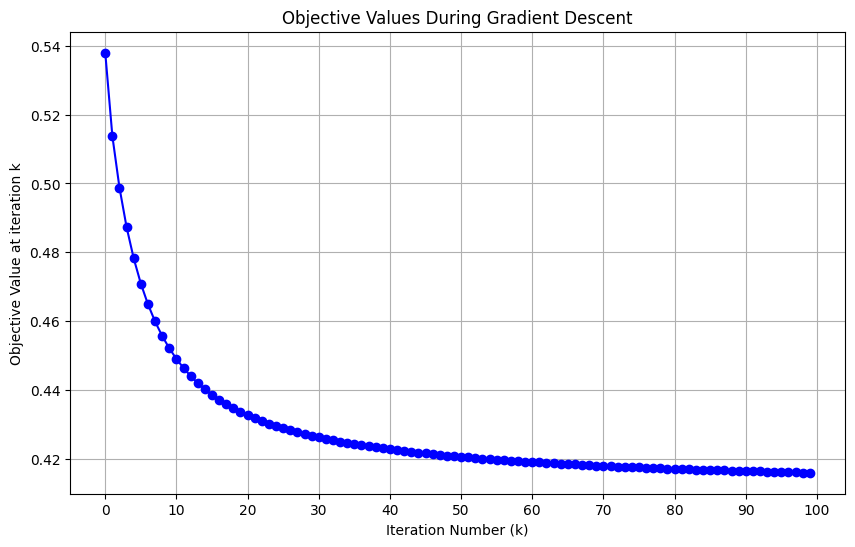

In [56]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(range(n_iter), obj_vals, marker='o', linestyle='-', color='b')
plt.title('Objective Values During Gradient Descent')
plt.xlabel('Iteration Number (k)')
plt.ylabel('Objective Value at iteration k')
plt.grid()
plt.xticks(np.arange(0, n_iter + 1, 10))
plt.show()

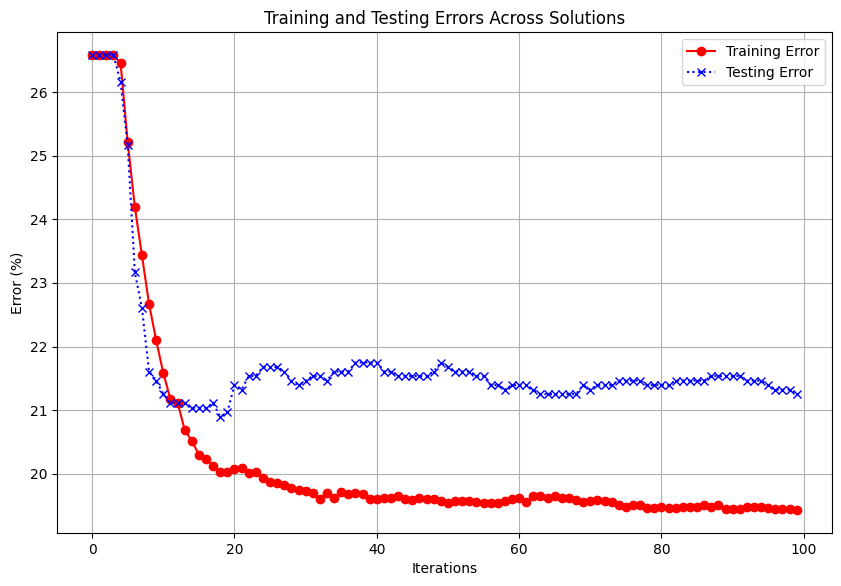

In [57]:
def compute_accuracy(testX, testY, sols):
    """
    returns the accuracy of each solution on the given dataset

    accuracy = percentage of correctly classified examples

    Parameters
    -----------
    testX, testY: input dataset
    sols: a list of parameter vectors

    Returns
    --------
    acc: a list of accuracies, each element corresponds to the accuracy of each solution in sols
    """
    acc = []

    n_examples = len(testY)

    for sol in sols:
        pred = predict(testX, sol)
        n_correct = n_examples - np.count_nonzero(testY - pred)
        acc.append((n_correct*100.0)/n_examples)

    return acc

train_accs = compute_accuracy(X_train, y_train, sols)
test_accs = compute_accuracy(X_test, y_test, sols)

train_errors = [100 - acc for acc in train_accs]  # Error = 100 - accuracy
test_errors = [100 - acc for acc in test_accs]

# Plot the training and test errors
plt.figure(figsize=(10, 6.5))
plt.plot(range(len(train_errors)), train_errors, marker='o', linestyle='-', color='red', label='Training Error')
plt.plot(range(len(test_errors)), test_errors, marker='x', linestyle=':', color='blue', label='Testing Error')
plt.title('Training and Testing Errors Across Solutions')
plt.xlabel('Iterations')
plt.ylabel('Error (%)')
plt.legend()
plt.grid()
plt.show()
